In [ ]:
Chapter 2  Group Exercise 2
Regression Analysis and Feature Selection

Group Members

Janvi Mahapadi
Devendra Ghawat
Kshitija Satpute


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression


In [2]:
# Create synthetic regression dataset
X, y = make_regression(
    n_samples=1200,
    n_features=30,
    noise=20,
    random_state=42
)

df = pd.DataFrame(X, columns=[f"Feature_{i}" for i in range(30)])
df["Target"] = y

df.head()


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Target
0,1.321371,0.187210,-0.481705,0.026210,-3.221167,-1.086945,-1.025330,-1.063825,0.156236,-1.355893,...,0.553506,-1.251471,1.561941,-0.421432,-0.975572,0.389986,0.136970,0.462771,2.068779,262.989174
1,-0.081838,0.027958,0.828987,1.381894,2.131764,1.062655,1.243559,1.122481,1.980289,0.366418,...,0.466424,0.676722,0.833160,-0.441747,-1.060033,-0.430043,0.891298,0.501022,-0.381883,143.765619
2,0.622823,0.418107,0.523173,-0.386575,-0.905285,-0.102313,-0.699983,0.900429,-1.746115,-0.015738,...,1.500257,-2.025539,-0.236863,-0.475355,0.750512,1.564830,0.013209,-0.134609,0.613680,16.820084
3,-1.099689,0.134370,1.569366,1.267395,0.455461,-1.215211,0.247064,-0.876246,-0.444434,-0.484366,...,-0.951479,3.002652,2.404805,-0.309260,-0.585404,-0.090732,1.281166,-0.780519,-0.142289,285.510849
4,-1.556537,-0.604138,0.926520,0.518513,-0.339205,0.637932,-0.585291,1.203460,0.534136,-0.878135,...,0.445644,-0.324475,1.186893,0.621256,0.952649,0.410921,0.744229,-0.462831,1.164465,172.037753


In [5]:
#Step 1: Preprocessing
# Handle Missing Values & Outliers
# Introduce missing values artificially
df.iloc[10:20, 0] = np.nan
df.iloc[30:40, 5] = np.nan
df.fillna(df.mean(), inplace=True)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]



In [7]:
#1.2 Feature Scaling
X = df.drop("Target", axis=1)
y = df["Target"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
#1.3 Feature Selection
selector = SelectKBest(score_func=f_regression, k=15)
X_selected = selector.fit_transform(X_scaled, y)

selected_features = X.columns[selector.get_support()]
selected_features


Index(['Feature_1', 'Feature_2', 'Feature_4', 'Feature_7', 'Feature_10',
       'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_17',
       'Feature_20', 'Feature_23', 'Feature_27', 'Feature_28', 'Feature_29'],
      dtype='object')

In [10]:
#Step 2: Build & Evaluate Models
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

#Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)


In [11]:
#Evaluation Metrics (R² & RMSE)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² Score:", r2)
print("RMSE:", rmse)


R² Score: 0.9936923946770891
RMSE: 18.522472639803304


In [12]:
#K-Fold Cross Validation (5-Fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    lr, X_selected, y,
    scoring='r2',
    cv=kf
)

print("Cross-validation R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())


Cross-validation R² scores: [0.99369239 0.99113433 0.99195857 0.9908669  0.99267109]
Mean CV R²: 0.9920646556291277


In [13]:
#Step 3: Model Enhancement
# Without feature selection
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

lr_full = LinearRegression()
lr_full.fit(X_train_full, y_train)

y_pred_full = lr_full.predict(X_test_full)

print("R² without feature selection:", r2_score(y_test, y_pred_full))
print("R² with feature selection:", r2)


R² without feature selection: 0.9936108410348758
R² with feature selection: 0.9936923946770891


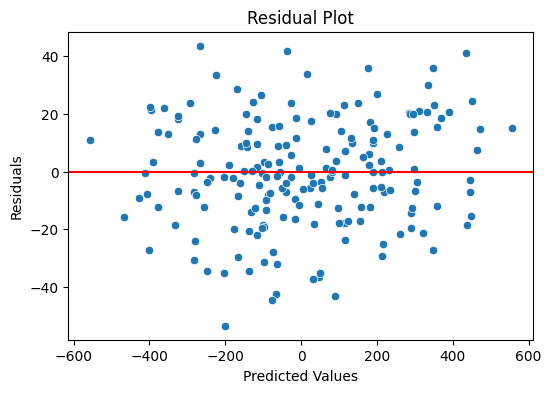

In [14]:
#Residual Plot
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


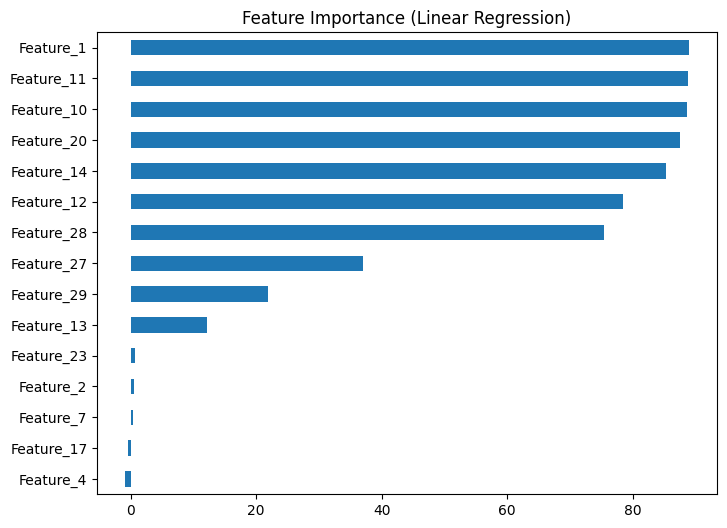

In [15]:
#Feature Importance
coefficients = pd.Series(lr.coef_, index=selected_features)

coefficients.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance (Linear Regression)")
plt.show()


In [16]:
#Step 4: Creativity & Advanced Models
#Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

print("R² Ridge:", r2_score(y_test, y_pred_ridge))


R² Ridge: 0.9936601975321295


In [17]:
#Lasso Regression
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

print("R² Lasso:", r2_score(y_test, y_pred_lasso))


R² Lasso: 0.9936839360946506


In [18]:
#Polynomial Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_selected)

X_train_p, X_test_p, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

lr_poly = LinearRegression()
lr_poly.fit(X_train_p, y_train)

y_pred_poly = lr_poly.predict(X_test_p)

print("R² Polynomial Regression:", r2_score(y_test, y_pred_poly))


R² Polynomial Regression: 0.9912025187913986


In [ ]:
Linear Regression provides interpretability and baseline performance.
Feature selection using SelectKBest reduced dimensionality and improved generalization.
Ridge regression controlled multicollinearity using L2 regularization.
Lasso regression performed implicit feature selection.
Polynomial regression captured non-linear patterns but increased complexity.

Regularization and feature selection significantly improved model robustness.
Residual analysis confirmed minimal bias and good error distribution.
